# Phase and cluster distributions over time

This is a notebook mostly for experimenting with different ways to visualize distributions / counts over time.

In [1]:
suppressPackageStartupMessages({
    library(Seurat)
    library(alluvial)
    library(tidyverse)
})

In [2]:
input_file = "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/adata_stripped.h5ad"
clusters_file = '/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/leiden_res0.4.csv'

In [3]:
suppressPackageStartupMessages({library(Seurat)})
srt = schard::h5ad2seurat(input_file)
# srt[['RNA']]$data = as.matrix(schard::h5ad2Matrix(input_file, name = "/layers/log1p_norm_of_counts"))
# stopifnot(!(all(srt[['RNA']]$data[1:50]%%1 == 0))) # check values (not integer)
# names(srt@reductions) = c('diffmap', 'pca', 'tsne', 'umap')
srt

An object of class Seurat 
11449 features across 113995 samples within 1 assay 
Active assay: RNA (11449 features, 0 variable features)
 2 layers present: counts, data
 4 dimensional reductions calculated: Xdiffmap_, Xpca_, Xtsne_, Xumap_

## Phases

In [ ]:
# count cells per phase and transform df into alluvial format
srt@meta.data[, c('phase', 'treatment', 'week')] |>
    table() |>
    as.data.frame() |>
    mutate(phase = factor(phase, levels = c("G1", "S", "G2M"))) -> counts

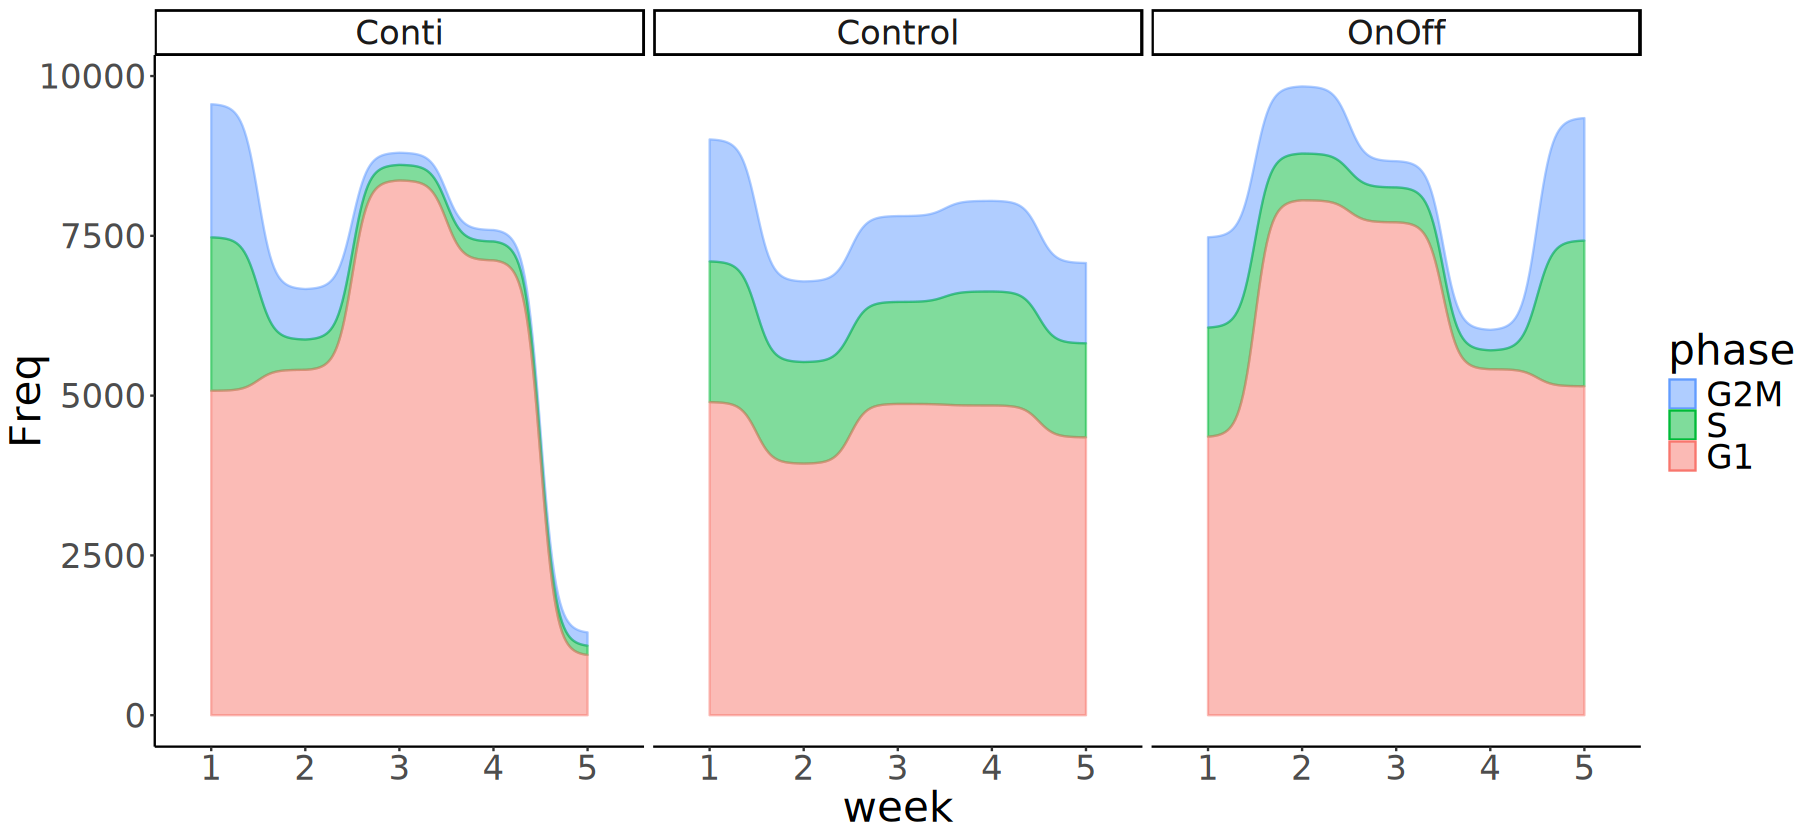

In [71]:
library(ggalluvial)
options(repr.plot.width = 15, repr.plot.height = 7)
colours_to_use = c('#f8766d', '#00ba38', '#619cff')
colours_phase_vectors = c("G1" = colours_to_use[1], "S" = colours_to_use[2], "G2M" = colours_to_use[3])
counts |>
    mutate(phase = factor(phase, levels = rev(c("G1", "S", "G2M")))) |>
    ggplot(aes(y = Freq, x = week, alluvium = phase)) + 
    geom_alluvium(aes(fill = phase, colour = phase),
                   decreasing = NA, width = 0, knot.pos = 0,
                   curve_type = "sigmoid") +
                   # different colors
    scale_color_manual(values = colours_phase_vectors) +
    scale_fill_manual(values = colours_phase_vectors) +
    facet_wrap(~treatment)  +
    theme_classic() +
    # increase font size
    theme(text = element_text(size=25))

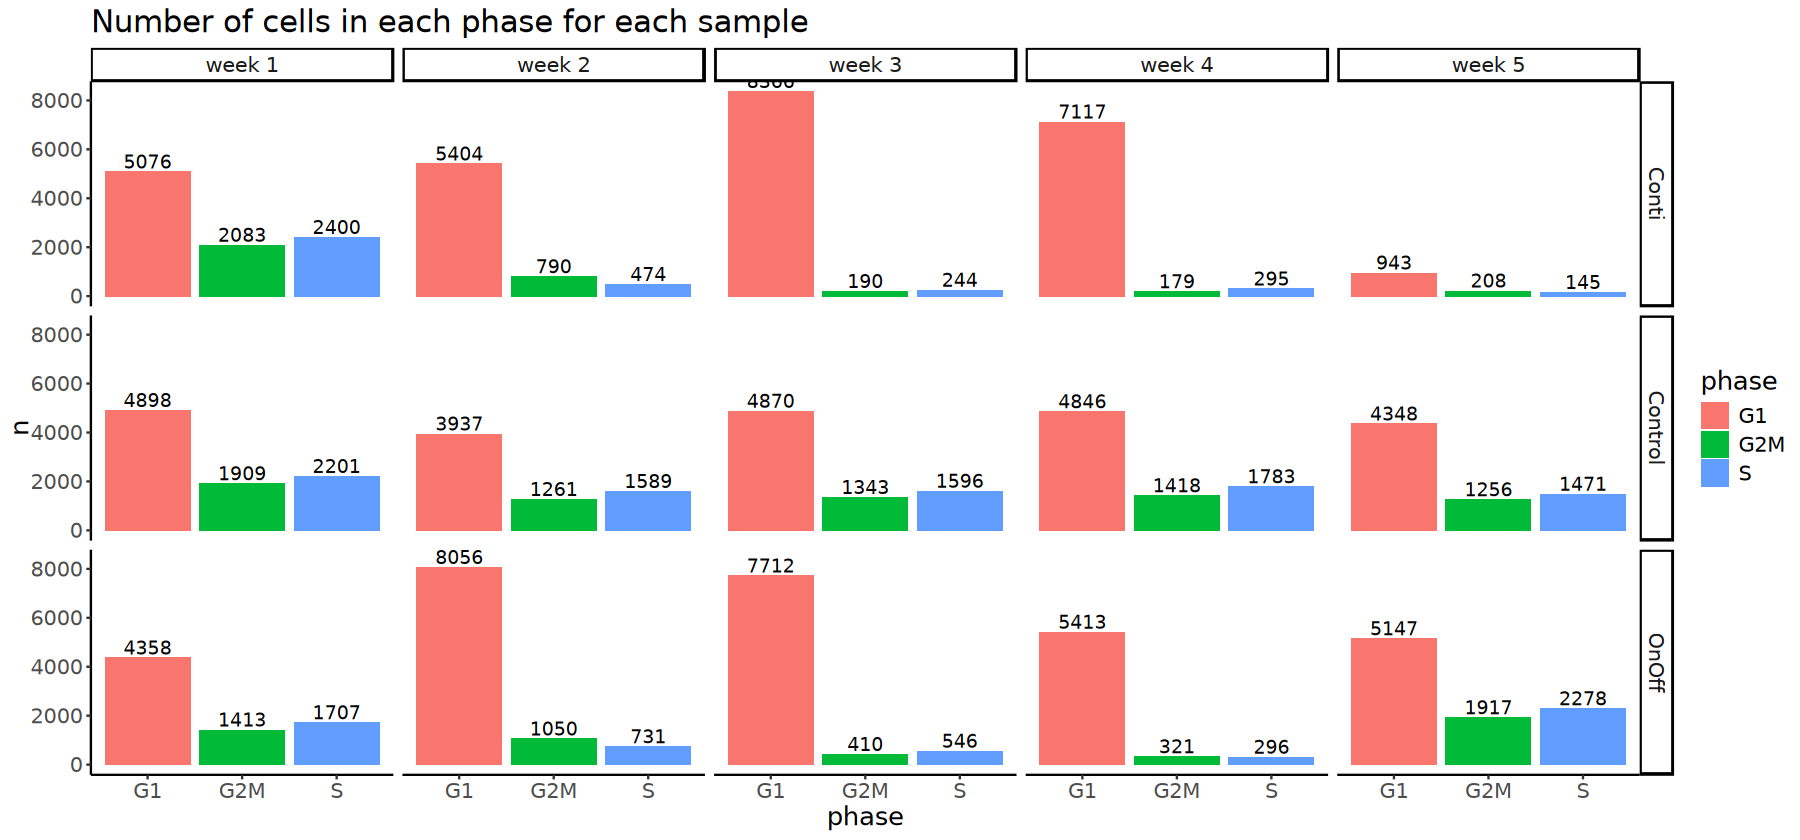

In [72]:
srt@meta.data[, c("phase", "treatment", "week")] %>%
    mutate(week = paste("week", week)) %>%
    dplyr::count(phase, treatment, week) %>%
    ggplot(aes(phase, n, fill = phase)) +
    geom_bar(stat = "identity", position = "dodge") +
    facet_grid(treatment ~ week) +
    labs(title = "Number of cells in each phase for each sample") +
    theme_classic() +
    theme(text = element_text(size = 15)) +
    geom_text(aes(label = n), position = position_dodge(width = 0.9), vjust = -0.25)

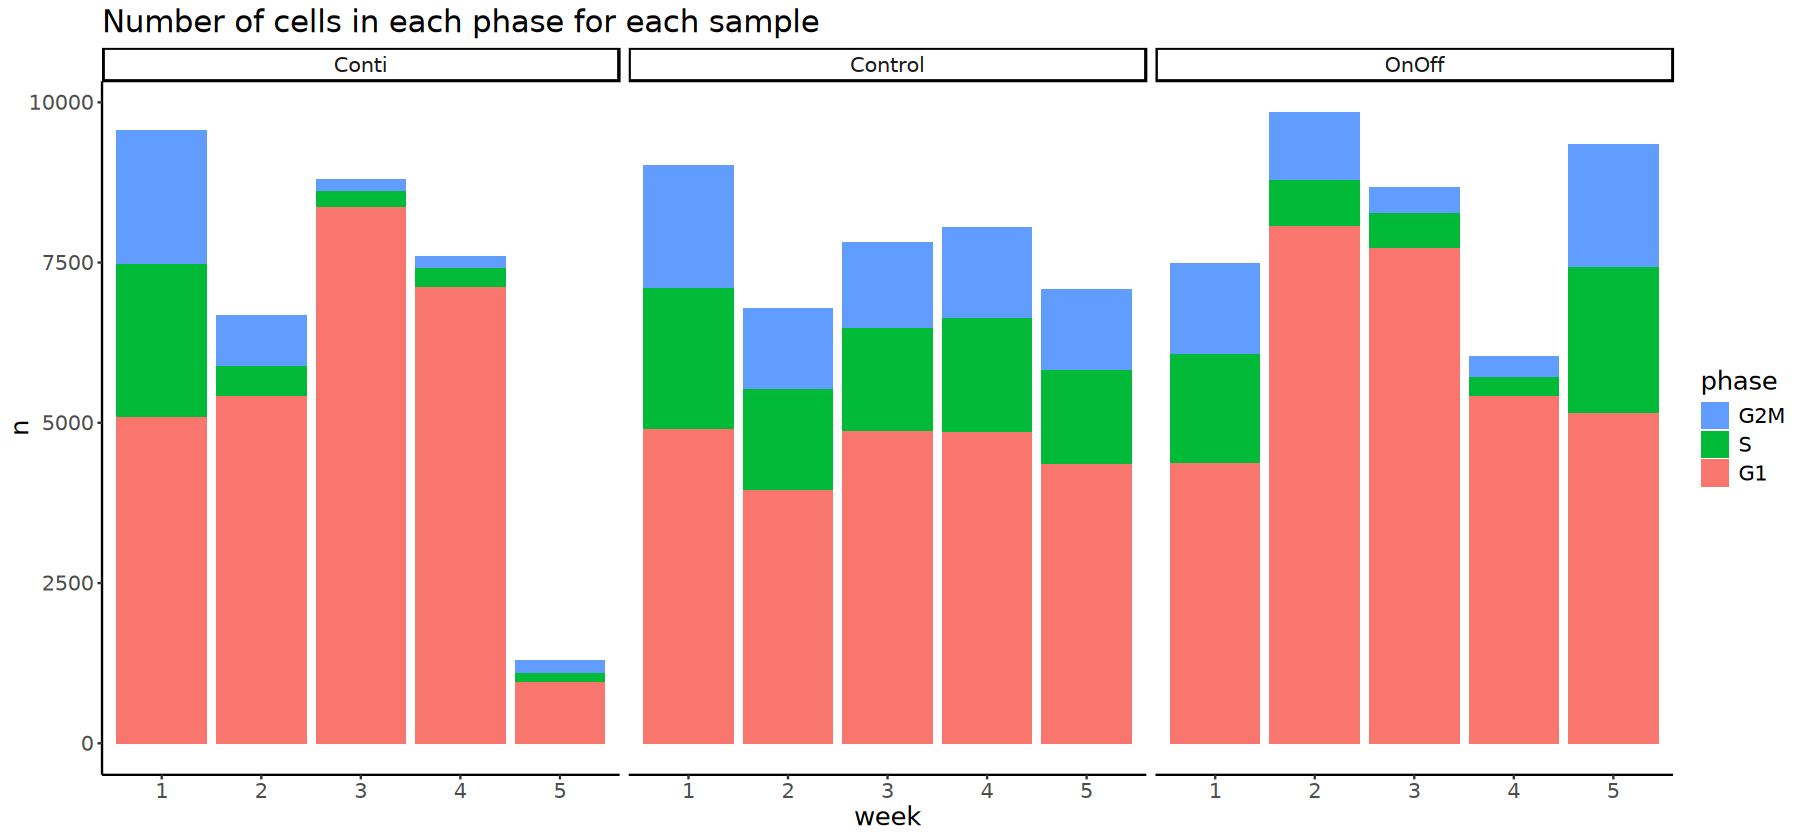

In [73]:
srt@meta.data[, c("phase", "treatment", "week")] %>%
  mutate(phase = factor(phase, levels = rev(c("G1", "S", "G2M")))) %>%
  dplyr::count(phase, treatment, week) %>%
  ggplot(aes(week, n, fill = phase)) +
  geom_bar(stat = "identity", position = "stack") +
  facet_grid(~treatment) +
  labs(title = "Number of cells in each phase for each sample") +
  xlab("week") +
  theme_classic() +
  theme(text = element_text(size = 15)) +
  scale_fill_manual(values = c("#619CFF", "#00BA38", "#F8766D"))

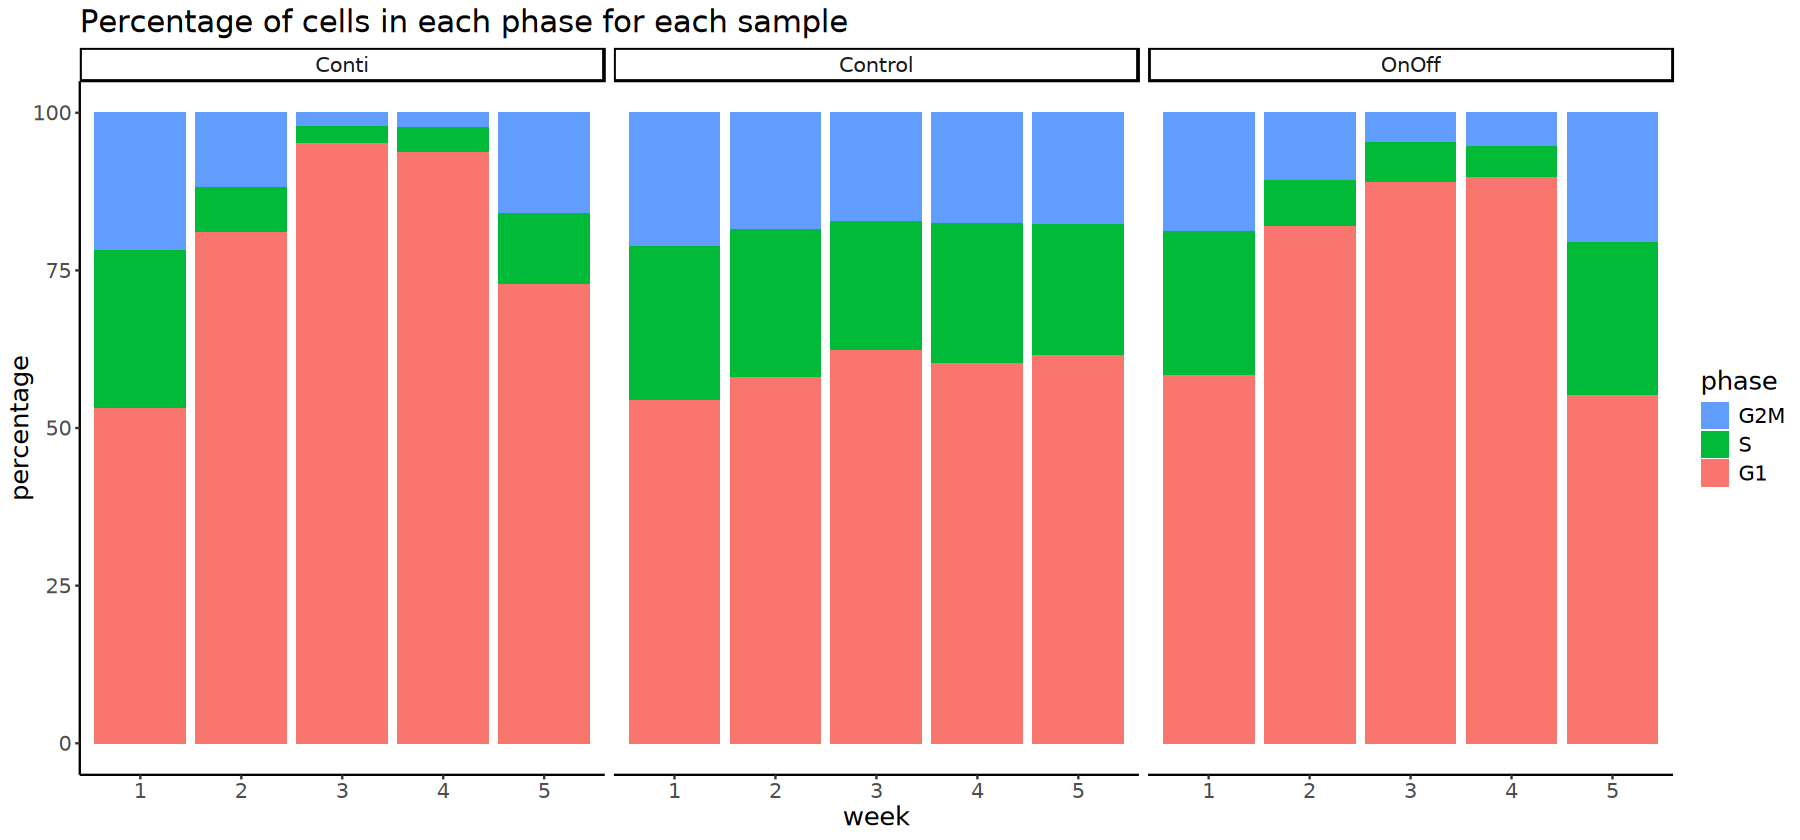

In [74]:
srt@meta.data[, c("phase", "treatment", "week")] %>%
  mutate(phase = factor(phase, levels = rev(c("G1", "S", "G2M")))) %>%
  dplyr::count(phase, treatment, week) %>%
  group_by(treatment, week) %>%
  mutate(percentage = n / sum(n) * 100) %>%
  ggplot(aes(week, percentage, fill = phase)) +
  geom_bar(stat = "identity", position = "stack") +
  facet_grid(~treatment) +
  labs(title = "Percentage of cells in each phase for each sample") +
  xlab("week") +
  theme_classic() +
  theme(text = element_text(size = 15)) +
  scale_fill_manual(values = c("#619CFF", "#00BA38", "#F8766D"))

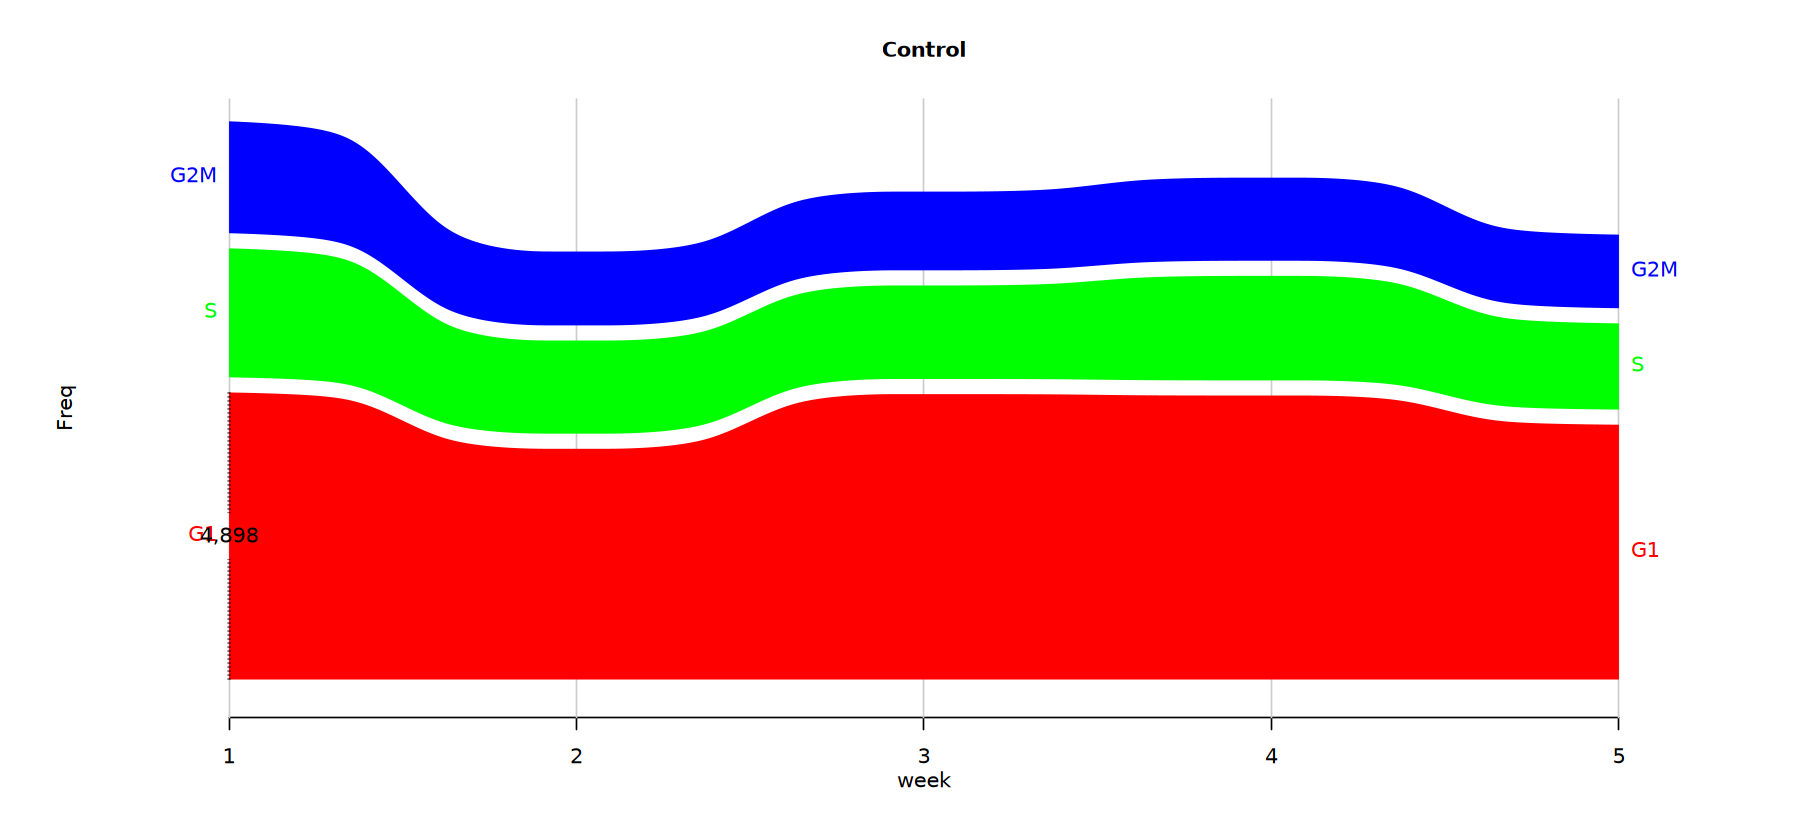

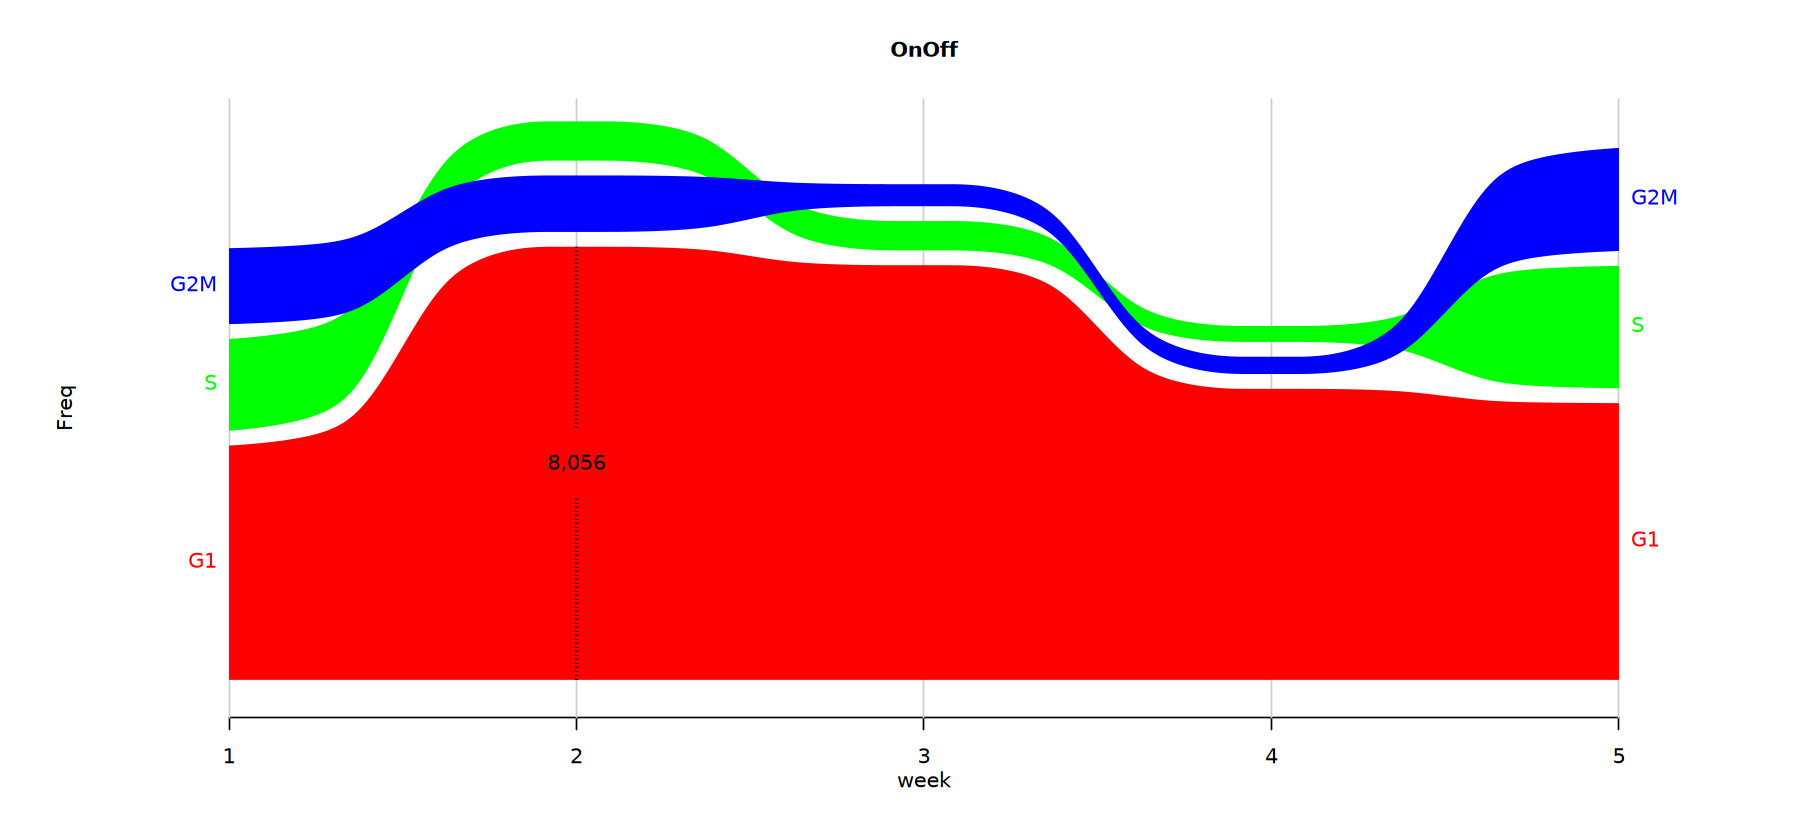

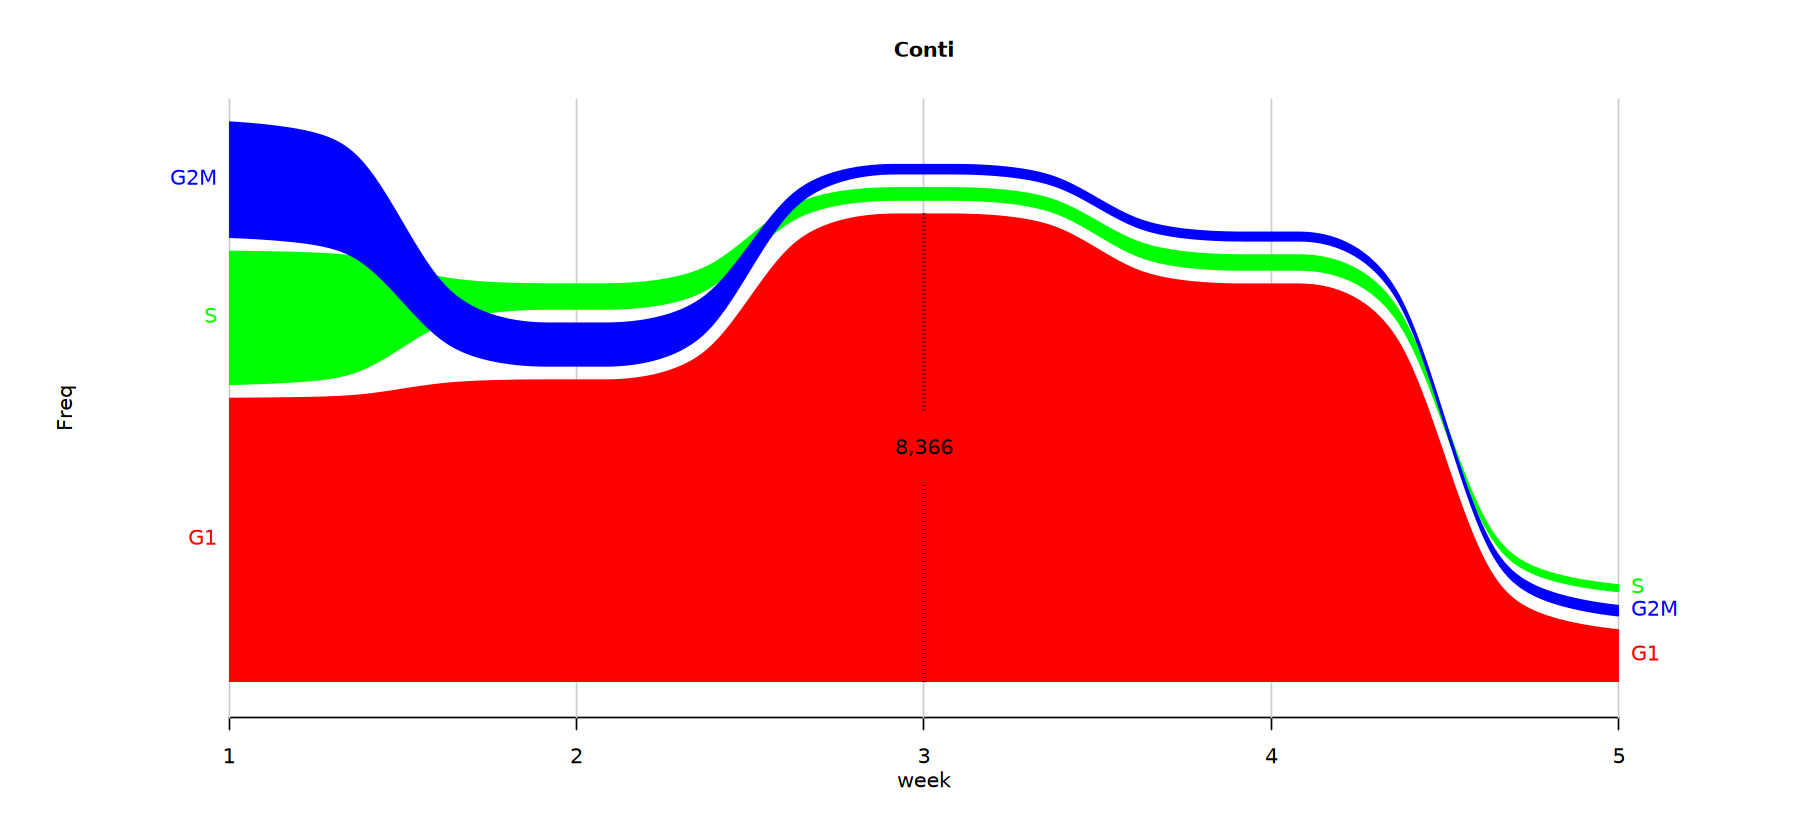

In [75]:

p1 = counts[counts$treatment == "Control", c(1,3,4)] |> 
    alluvial_ts(rankup = TRUE, title = "Control", grid=TRUE, lwd = 0.01)
p2 = counts[counts$treatment == "OnOff", c(1,3,4)] |> 
    alluvial_ts(rankup = TRUE, title = "OnOff", grid=TRUE, lwd = 0.01)
p3 = counts[counts$treatment == "Conti", c(1,3,4)] |> 
    alluvial_ts(rankup = TRUE, title = "Conti", grid=TRUE, lwd = 0.01)

## Clusters

In [76]:
clusters = read.csv(clusters_file) |> dplyr::rename(cluster = !!2) |> tibble::column_to_rownames("X")
stopifnot(all(rownames(srt@meta.data) == rownames(clusters))) # check if same cells
srt$clusters = clusters

In [77]:
clusters = srt@meta.data[, c('clusters', 'treatment', 'week')]
clusters |> head()

,clusters,treatment,week
,<int>,<chr>,<chr>
AAACAAGCAAACACGCATCCCAAC-1,2,Conti,1
AAACAAGCACTAAGGCATCCCAAC-1,1,Conti,1
AAACAAGCAGCACTAAATCCCAAC-1,5,Conti,1
AAACAAGCATTTGGGAATCCCAAC-1,2,Conti,1
AAACCAATCAAGGGCCATCCCAAC-1,2,Conti,1
AAACCAATCATGAATGATCCCAAC-1,2,Conti,1


In [78]:
# count occurrences
counts = as.data.frame(table(clusters))
counts$clusters = factor(counts$clusters)
counts |> head()

,clusters,treatment,week,Freq
,<fct>,<fct>,<fct>,<int>
1,0,Conti,1,136
2,1,Conti,1,1300
3,2,Conti,1,4920
4,3,Conti,1,152
5,4,Conti,1,59
6,5,Conti,1,2739


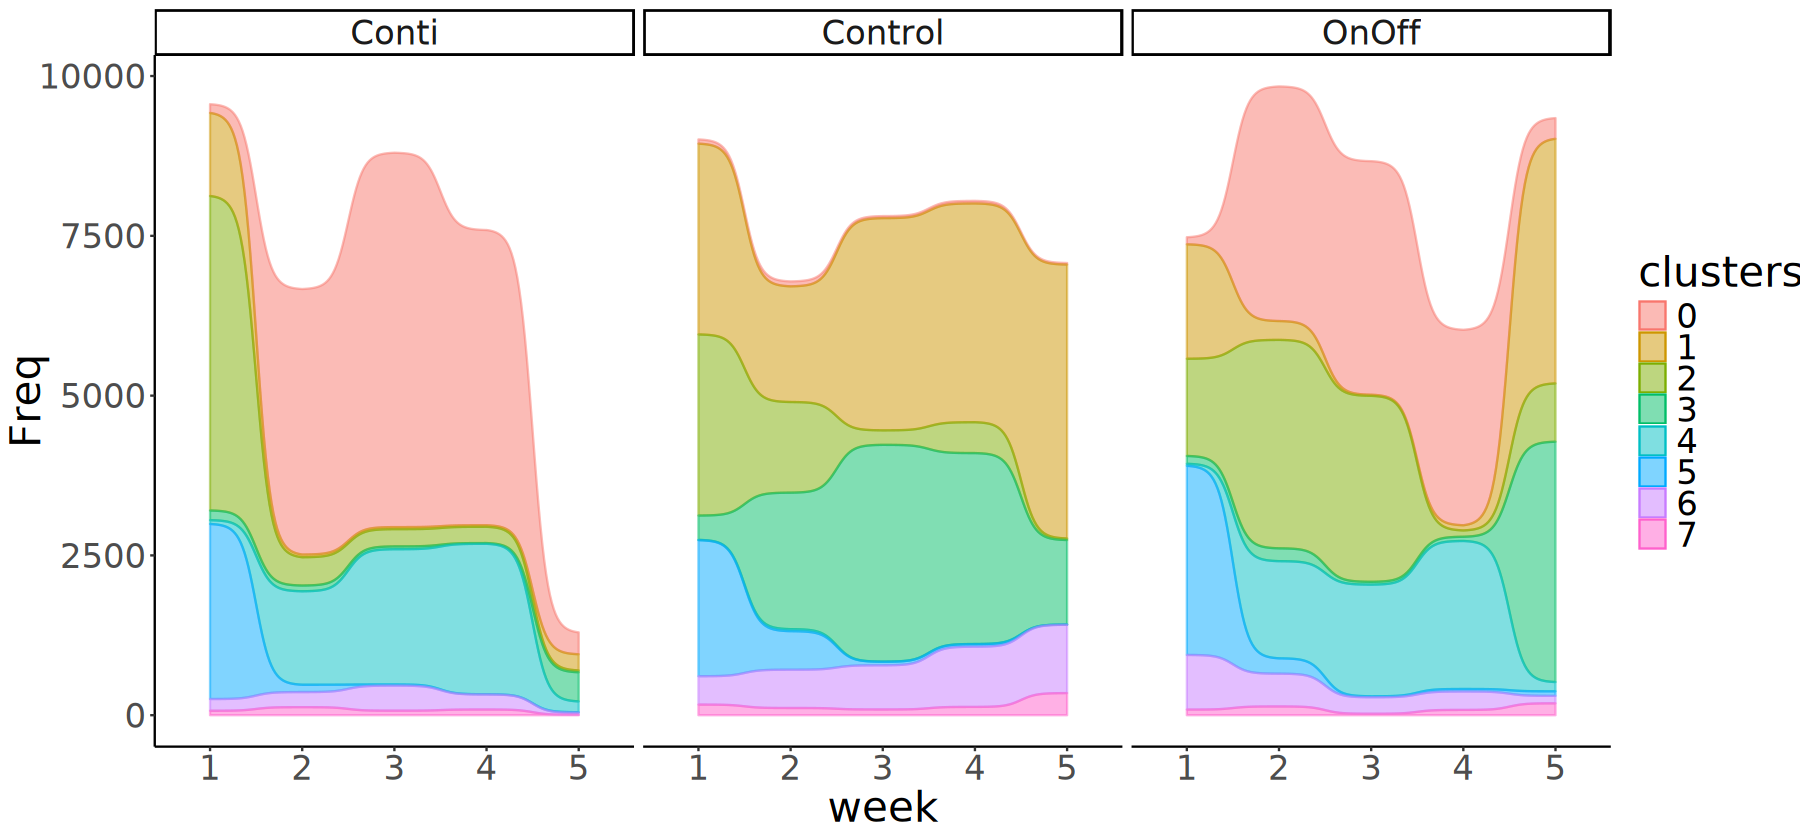

In [79]:
library(ggalluvial)
options(repr.plot.width = 15, repr.plot.height = 7)
# colours_to_use = c('#f8766d', '#00ba38', '#619cff')
# colours_phase_vectors = c("G1" = colours_to_use[1], "S" = colours_to_use[2], "G2M" = colours_to_use[3])
counts |>
    mutate(clusters = factor(clusters)) |>
    ggplot(aes(y = Freq, x = week, alluvium = clusters)) + 
    geom_alluvium(aes(fill = clusters, colour = clusters),
                   decreasing = NA, width = 0, knot.pos = 0,
                   curve_type = "sigmoid") +
                   # different colors
    # scale_color_manual(values = colours_phase_vectors) +
    # scale_fill_manual(values = colours_phase_vectors) +
    facet_wrap(~treatment)  +
    theme_classic() +
    # increase font size
    theme(text = element_text(size=25))

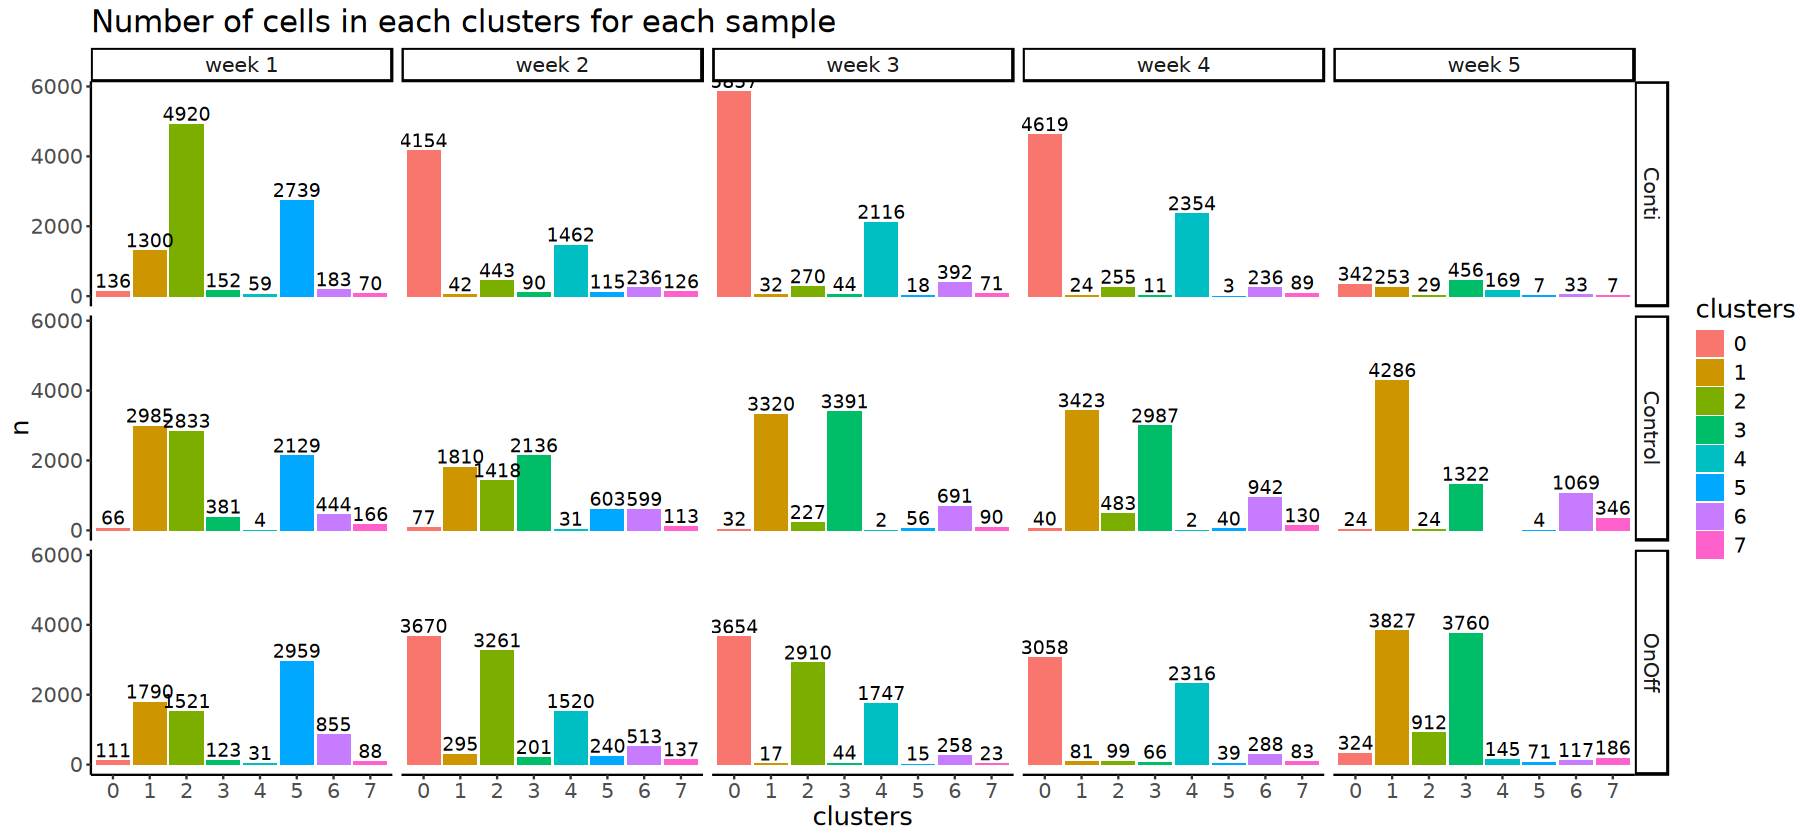

In [80]:
srt@meta.data[, c("clusters", "treatment", "week")] %>%
    mutate(week = paste("week", week)) %>%
    mutate(clusters = factor(clusters)) %>%
    dplyr::count(clusters, treatment, week) %>%
    ggplot(aes(clusters, n, fill = clusters)) +
    geom_bar(stat = "identity", position = "dodge") +
    facet_grid(treatment ~ week) +
    labs(title = "Number of cells in each clusters for each sample") +
    theme_classic() +
    theme(text = element_text(size = 15)) +
    geom_text(aes(label = n), position = position_dodge(width = 0.9), vjust = -0.25)

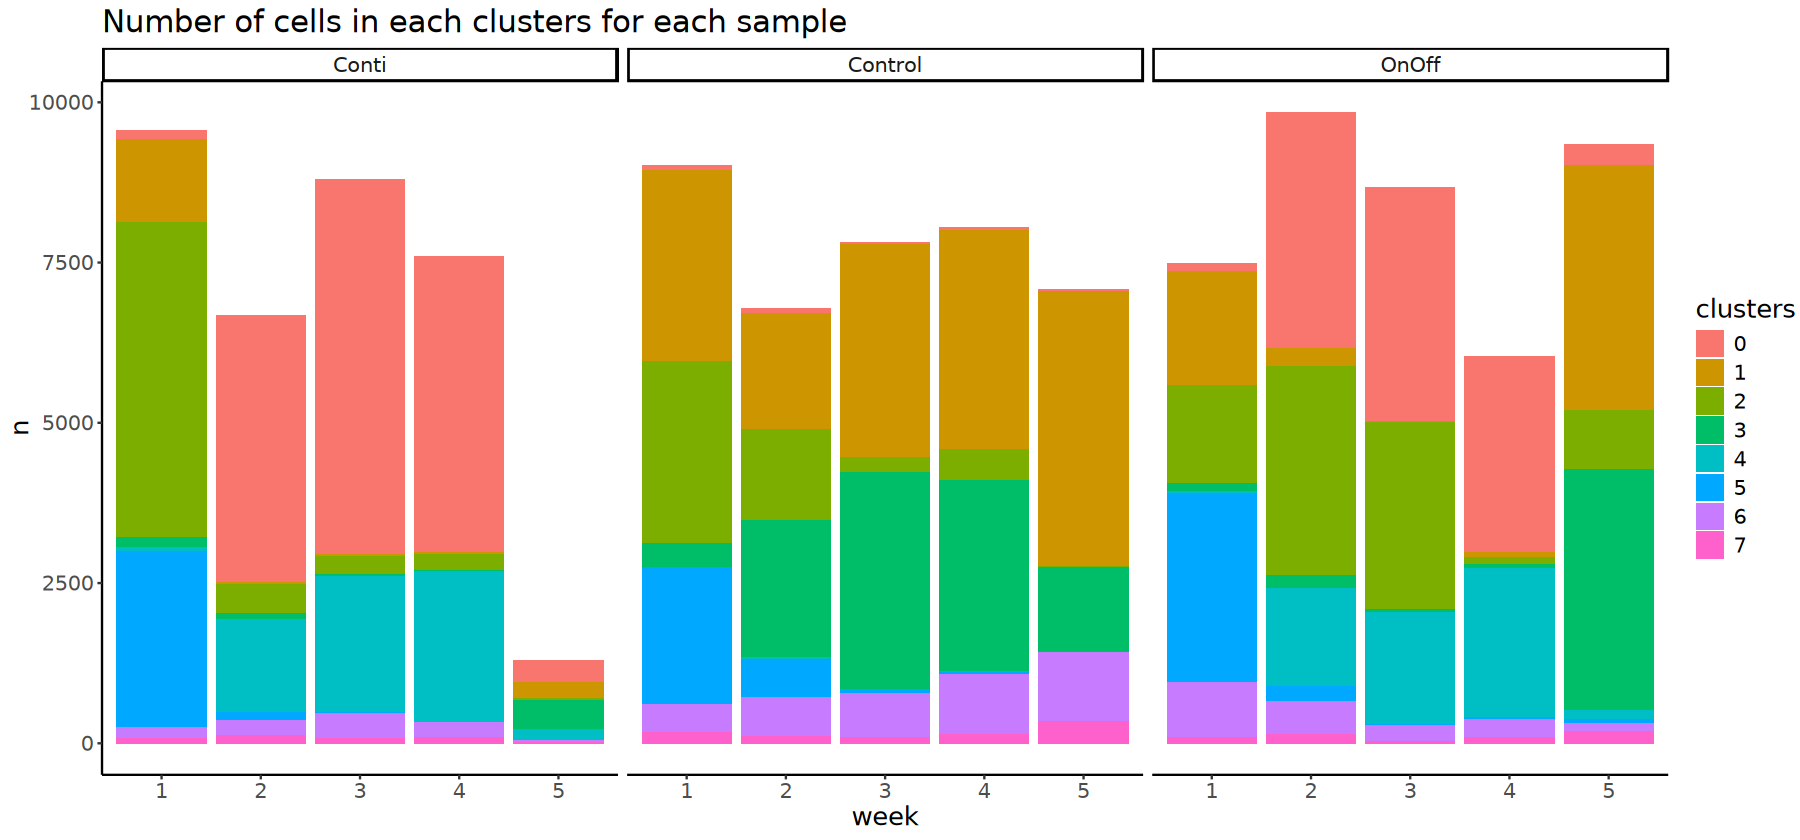

In [81]:
srt@meta.data[, c("clusters", "treatment", "week")] %>%
  mutate(clusters = factor(clusters)) %>%
  dplyr::count(clusters, treatment, week) %>%
  ggplot(aes(week, n, fill = clusters)) +
  geom_bar(stat = "identity", position = "stack") +
  facet_grid(~treatment) +
  labs(title = "Number of cells in each clusters for each sample") +
  xlab("week") +
  theme_classic() +
  # scale_fill_manual(values = c("#619CFF", "#00BA38", "#F8766D")) +
  theme(text = element_text(size = 15))

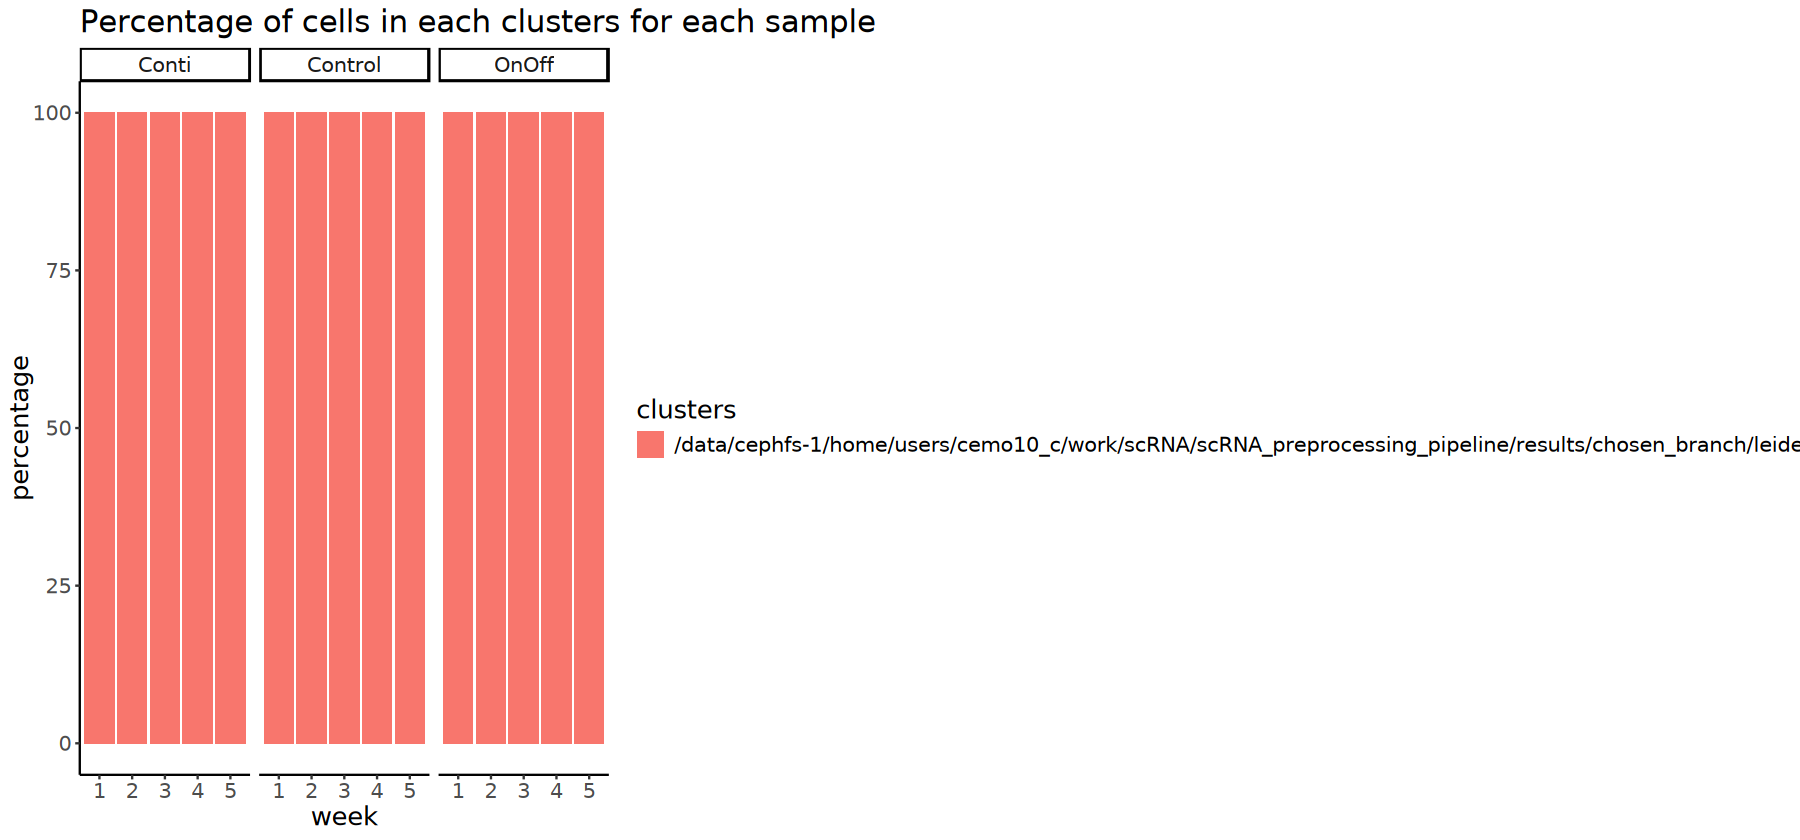

In [82]:
srt@meta.data[, c("clusters", "treatment", "week")] %>%
  mutate(clusters = factor(clusters_file)) %>%
  dplyr::count(clusters, treatment, week) %>%
  group_by(treatment, week) %>%
  mutate(percentage = n / sum(n) * 100) %>%
  ggplot(aes(week, percentage, fill = clusters)) +
  geom_bar(stat = "identity", position = "stack") +
  facet_grid(~treatment) +
  labs(title = "Percentage of cells in each clusters for each sample") +
  xlab("week") +
  theme_classic() +
  # scale_fill_manual(values = c("#619CFF", "#00BA38", "#F8766D")) +
  theme(text = element_text(size = 15))

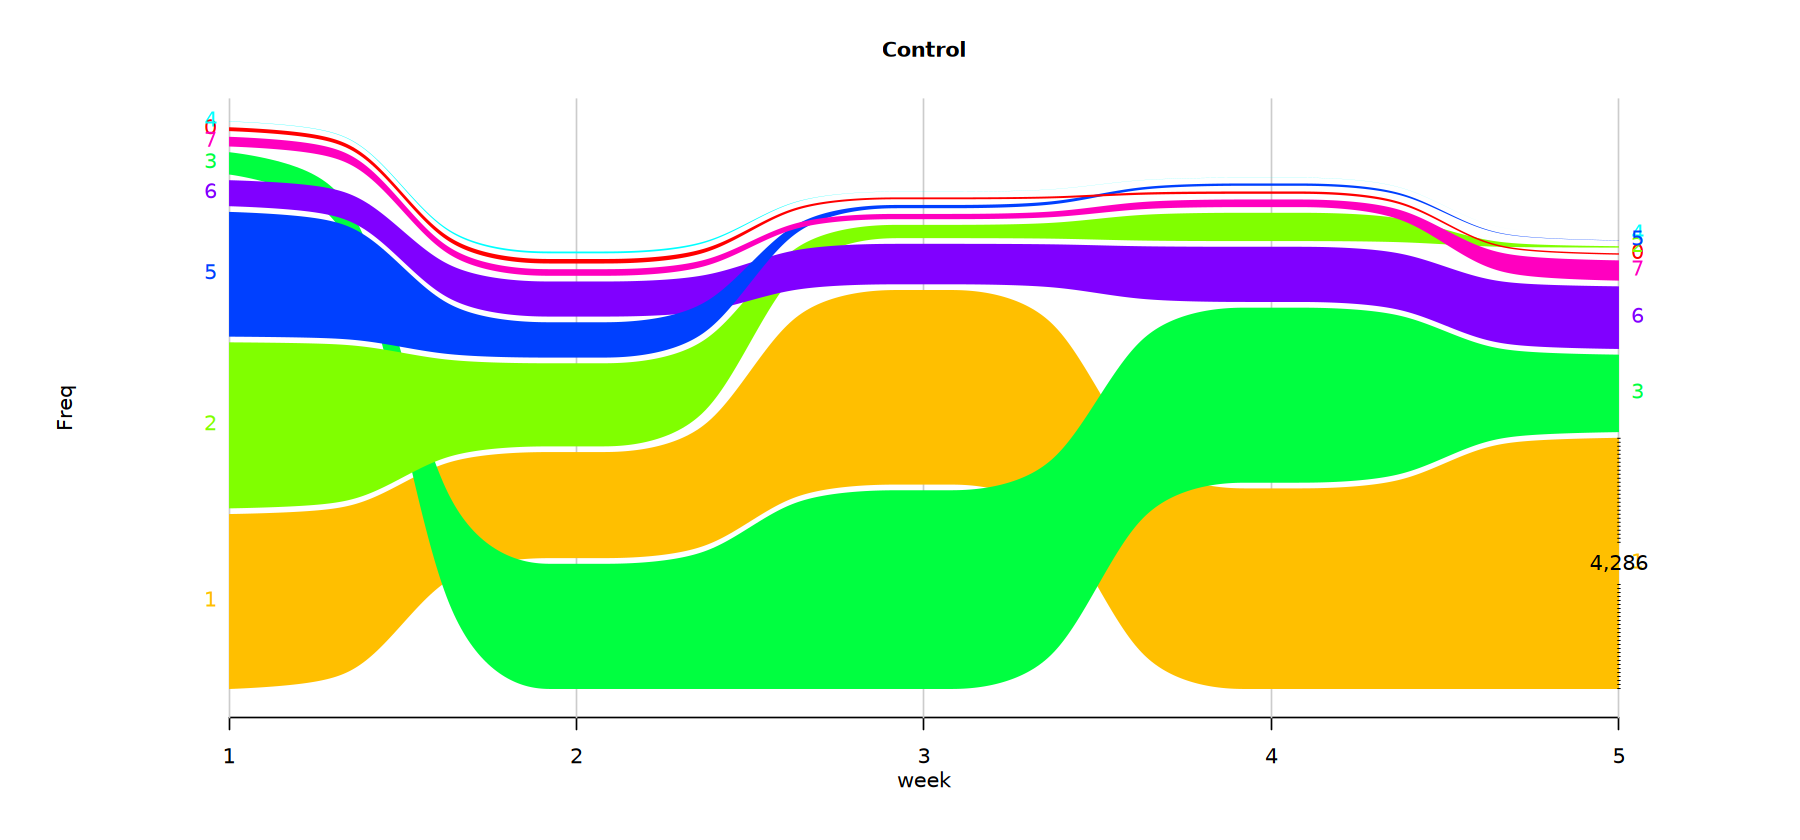

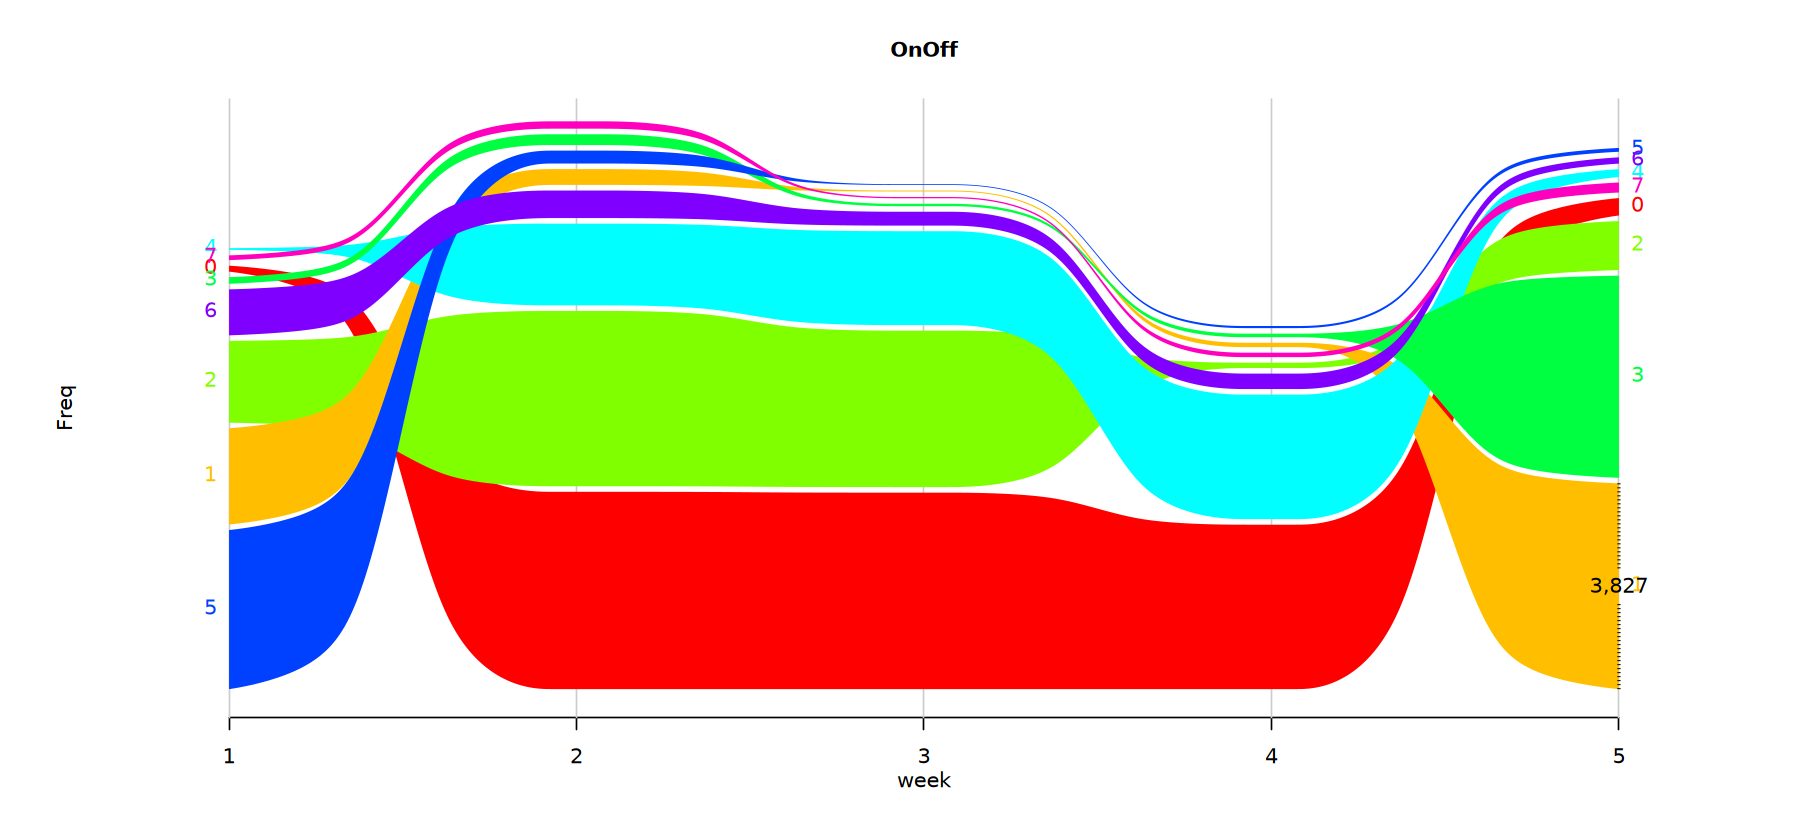

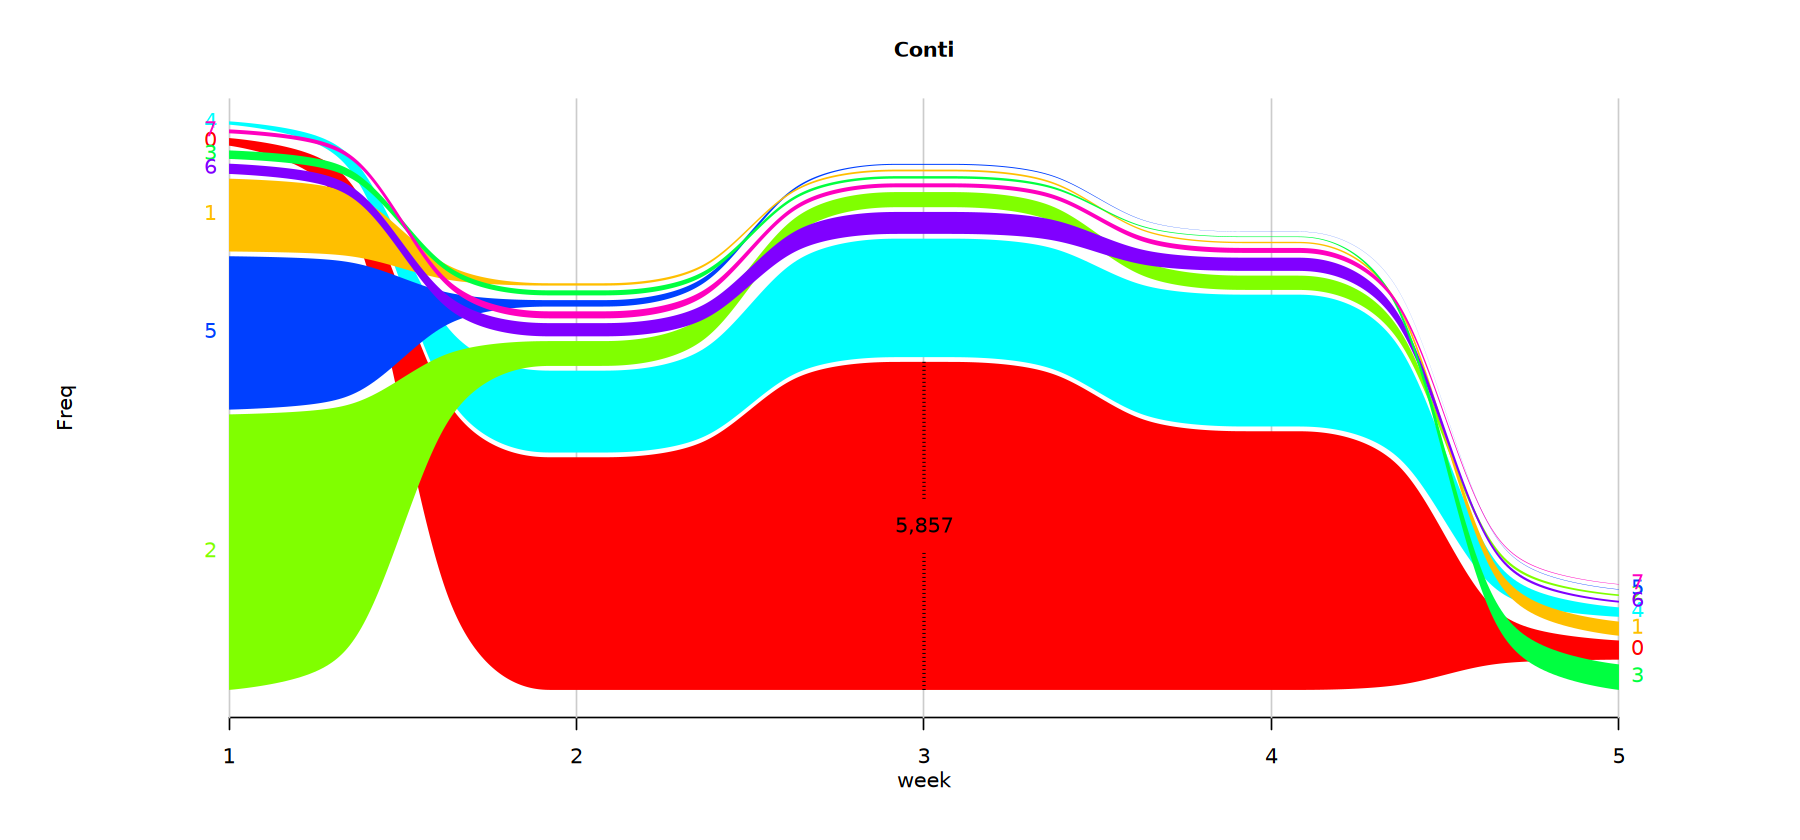

In [83]:
p1 = counts[counts$treatment == "Control", c(1,3,4)] |> 
    alluvial_ts(rankup = TRUE, title = "Control", grid=TRUE, lwd = 0.01)
p2 = counts[counts$treatment == "OnOff", c(1,3,4)] |> 
    alluvial_ts(rankup = TRUE, title = "OnOff", grid=TRUE, lwd = 0.01)
p3 = counts[counts$treatment == "Conti", c(1,3,4)] |> 
    alluvial_ts(rankup = TRUE, title = "Conti", grid=TRUE, lwd = 0.01)

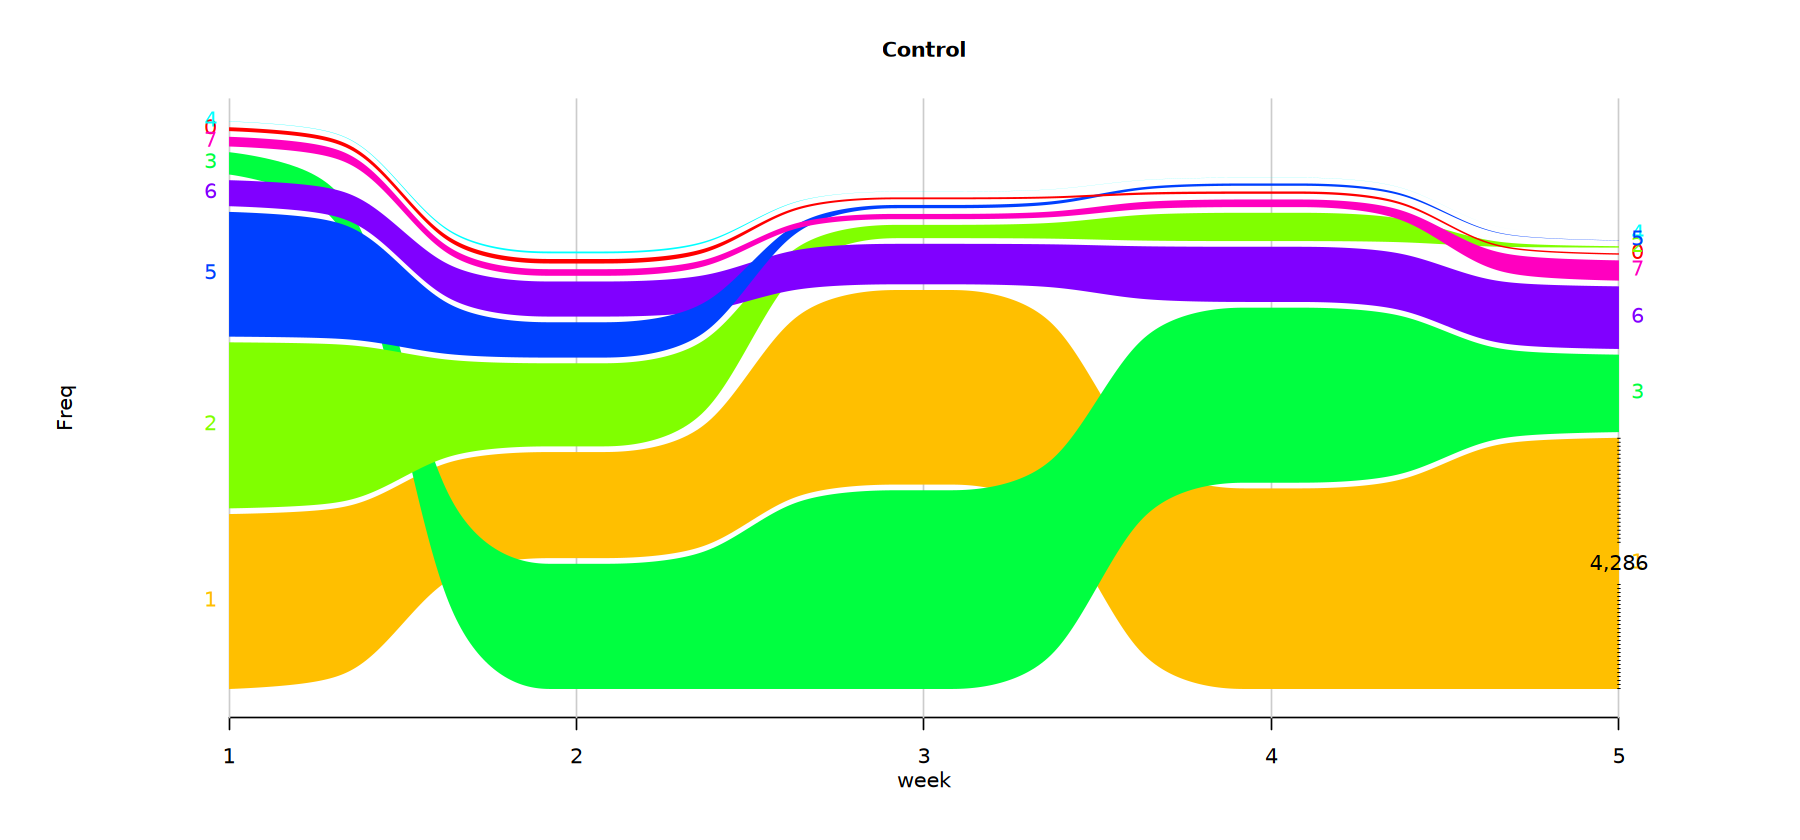

In [84]:
counts[counts$treatment == "Control", c(1,3,4)] |> 
    alluvial_ts(rankup = T, title = "Control", grid=TRUE, lwd = 0.01)